In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/df_train.csv')
df

,Unnamed: 0,day,hashed_partner_id,hashed_campaign_id,contextid,display_env,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,...,nbdisplayglobalapprox_1d_sum_xdevice,hashed_uid,hashed_xd_id,valueperclick,device_type,display_width,display_height,display_timestamp,is_display_clicked,zonecostineuro
0,0,2020-10-19,b'=\xa6\xeef\x99\xda\x1e\xb5-5\x8a\xa5\x9b\x8e...,"b""f|g\xd5T\xc8\xe2\x90\xc6\xc8\xfeL\x0c\x15\xe...",6,web,1,74.0,0.0,127.0,...,23.000000,b'\x99w[\xb8\xe1\x9e\xbaz\x01\x06\x9c\xdc\x03\...,b'\xdb\xfc\xdfBY`$\x97\xf9\xaaGn\x98\xe0{RQ\x9...,0.529218,Android,0,0,1603150590,0,0.366238
1,1,2020-10-19,b'=\xa6\xeef\x99\xda\x1e\xb5-5\x8a\xa5\x9b\x8e...,b'7\xa0%5\x98\x02\x00\xe5\xa2\xfb\xd6\xa9^\xb7...,0,web,1,74.0,0.0,127.0,...,98.252222,b'>\x1a\x00W\xb0\x81\x06\x00\x90\xc8\x8aL\xb4\...,b'\xe9\xcd\x80\xb5\x96\xcf8\x8eo(p-\x0f\xf4\xf...,0.269752,Desktop,0,0,1603150640,0,0.025551
2,2,2020-10-19,"b'\xa1l\n\xb2`\xe3\x0b""\xcd\x06\xfa\xdf\x9aj0\...","b'\xbe\xa0?\xc2</,\xa4&w\x86\xe9\x150Y\xd4\xdf...",6,web,1,4.0,2.0,10.0,...,11.000000,b'o\xa5~{\xf5\xd0C\xac_\xa9\x10\x95\x04L\x8a\x...,b'o\xa5~{\xf5\xd0C\xac_\xa9\x10\x95\x04L\x8a\x...,0.095993,Android,640,150,1603150780,0,0.289000
3,3,2020-10-19,b'=\xa6\xeef\x99\xda\x1e\xb5-5\x8a\xa5\x9b\x8e...,b'7\xa0%5\x98\x02\x00\xe5\xa2\xfb\xd6\xa9^\xb7...,6,web,1,73.0,1.0,127.0,...,57.000000,b'\xf2\x93e\xae\xadBh\x9f<<\x9e\xf0\x91q\xba\x...,"b'\x83u\xce\x10n\x9f\x10hP\x0cI\xdb \xed\xa8,E...",0.269752,iPhone,2,2,1603150840,0,0.243945
4,4,2020-10-19,b'\x0f\xbc\x909\x14[dI\xa7v]\xcc\x00\xd3\xbd\x...,b'\xa0\t^\xa5Z\x06[-\x86\x13\xd8\x08\x98\x8de\...,8,app_ios,2,74.0,0.0,127.0,...,2.000000,b'\xe6\xa9\xb2:\xc5\x04\xfd\x89/Lg\xc1\x0e\xa4...,b'\xe6\xa9\xb2:\xc5\x04\xfd\x89/Lg\xc1\x0e\xa4...,0.136416,iPhone,0,0,1603149970,0,0.647304
5,5,2020-10-19,"b'\xa1l\n\xb2`\xe3\x0b""\xcd\x06\xfa\xdf\x9aj0\...",b'l\xf5\x89f\x00\xcb\xb0rdO\xcd\xfaN\x8b\xad!Y...,6,web,1,4.0,2.0,3.0,...,24.192269,"b',\xb4\xc6\xb2[6:\x98V\x15\x18G\xbf\xd1\x04\x...","b',\xb4\xc6\xb2[6:\x98V\x15\x18G\xbf\xd1\x04\x...",0.079757,Desktop,0,0,1603150020,0,0.310000
6,6,2020-10-19,b'\xa3w\x0e\x92#\xa6\xa8\x1b\xe2\xbeS\x85C\x10...,b'%\x01\xb1\xdf)Dh\x9f=j\xe81my\xf9\xa3\xe1\xd...,9,web,1,4.0,1.0,10.0,...,48.251389,b'f6j.$\xc7\x80\xf4g\x9a\xb2\xb5A\x9d\xd9M+\x8...,b'\x12\xb97|\xbe~\\\x94\xe8\xa7\r\x9d#\x92\x95...,0.153244,Desktop,970,250,1603150200,0,0.597000
7,7,2020-10-19,b'F\xb7$\xb2\xf8]O{\xd4\x85B:\x04\xbc\xf2\xcf\...,b'pM~\xcf%E\x96.\xc6i\\\xb3\x97o\xc7q4j\x9c\xd...,9,web,1,10.0,1.0,16.0,...,15.514815,"b""\xf7'\xf4\x8e\xf8W\xf9K\xdd\xf4<!q4\xd4\xca\...",b'k\x7f\xbe_o\xda3)K\xcf\xfbP\x02.[\x9d.\xe5\x...,0.144947,Android,300,250,1603150370,0,0.102206
8,8,2020-10-19,b'F\xb7$\xb2\xf8]O{\xd4\x85B:\x04\xbc\xf2\xcf\...,"b'eA\xa1\\\x11\xce\xa9&}W\xccq\x16\x1f\xd0""%\x...",9,web,1,73.0,2.0,127.0,...,78.090278,"b'/),\xeb\x1f4v]h\xb7]r}\xcf(\xd8\x85\xd1=\xb4...",b'\xb4\x02\xba\xae\xea\xcf\xae\xbaZ\xcb\xbc\x8...,0.137768,Android,336,280,1603150440,0,0.625672
9,9,2020-10-19,b'5IH\xefa\xd1\x01I\xfa\x91\xad\x1b\xf6\xa8go\...,b'|\xc9\x17R$I\xfb\xc76\x8c3}3^a\x99yaM\x1c\x9...,5,web,1,6.0,2.0,12.0,...,1.000000,b'E\xe66\x17\x7fs\xfd\xfa\xb1\x9d\xe6;\x03\xa9...,b'\x12\xb97|\xbe~\\\x94\xe8\xa7\r\x9d#\x92\x95...,0.254042,Android,300,250,1603150490,0,0.085163


In [3]:
df_acp = df[['dayssincelastvisitdouble','nbdayssincelastclick','valueperclick','display_width', 'display_height','zonecostineuro']]

In [4]:
import sklearn # On importe scikit-learn.
# On centre et réduit les variables de manière à effectuer une ACP normée.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
Z

array([[-0.40403074, -0.31888368,  1.53838577, -1.16127732, -1.0182392 ,
        -0.24102529],
       [-0.44500845, -0.4331644 ,  0.116663  , -1.16127732, -1.0182392 ,
        -0.36147793],
       [-0.33272245, -0.29602753, -0.83543587,  1.30258645, -0.36348024,
        -0.26833344],
       ...,
       [-0.36338698, -0.34173982,  1.37883319,  0.07065456,  1.07698948,
         1.67659239],
       [-0.41283132,  0.7553551 , -0.56245648, -0.00634118,  0.07302573,
        -0.36344071],
       [-0.16001102, -0.4331644 ,  0.14436709, -0.00634118,  1.60079664,
        -0.1780584 ]])

In [5]:
from sklearn.decomposition import PCA
# Instanciation de l'objet PCA
acp = PCA(svd_solver='full')

In [6]:
# Calcul des coordonnées factorielles
coord = acp.fit_transform(Z)
# Vérification du nombre de composantes principales
print(acp.n_components_)

6


In [7]:
print(acp.explained_variance_ratio_)

[0.23178158 0.20112303 0.17281194 0.14226451 0.13263845 0.1193805 ]


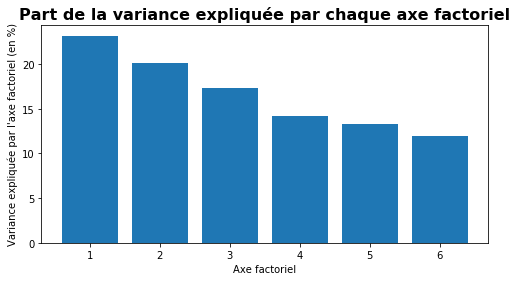

In [8]:
plt.figure(figsize=(8,4))
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Part de la variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

In [9]:
df.isnull().sum()

Unnamed: 0                                              0
day                                                     0
hashed_partner_id                                       0
hashed_campaign_id                                      0
contextid                                               0
display_env                                             0
target_env                                              0
rtbtypeid                                            9066
rtbadvisibility                                      9066
rtb_detectedlanguage                                 9066
urlhash2                                           155695
urlhash3                                           155695
urlhash4                                           155695
user_country                                          366
hashed_affiliateid                                      0
hashed_app_id                                      736418
googleviewability                                 1278860
googlepagevert

In [ ]:
fig, axes = plt.subplots(figsize=(10,6))
axes.set_xlim(-5,10)
axes.set_ylim(-5,10)

for i in range(len(coord[:,0])):
    if df['is_display_clicked'][i] == 0:
        axes.text(coord[i,0], coord[i,1], str(df_acp.index[i]), size=6, color='r')
    else :
        axes.text(coord[i,0], coord[i,1], str(df_acp.index[i]), size=6, color='g')

axes.scatter(coord[:,0], coord[:,1])
plt.show()